# Classical and Sequential A/B testing analysis

## Data Exploration

The BIO data for this project is a "Yes" and "No" response on online users to the following question.
```
Q: Do you know the brand SmartAd?
```
The users that were presented with the questionaire above were chosen according to the following rule:
```
Control: users who have been shown a dummy ad
Exposed: users who have bee shown a creative, online interactive ad with with SmartAd brand.
```

In [183]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
data = pd.read_csv('AdSmartABdata.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [17]:
data = data.astype({'date': 'datetime64', 'platform_os' : 'object'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   object        
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 568.0+ KB


In [23]:
data.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     270
platform_os       3
browser          15
yes               2
no                2
dtype: int64

### Categorical Variables Unique Count

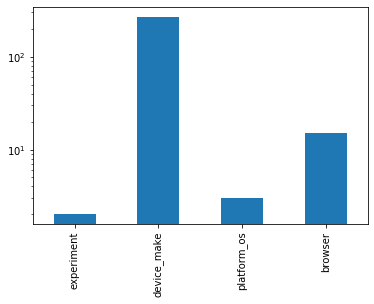

In [32]:
#the auction_id is the unique identifier for our dataset thus the huge number of unique values, 
#we'll exclude the column from our dataframe to have a better understanding of the data
BIO_data = data.drop(['auction_id'], axis=1)

#then we draw insights for categorical variables only in the remmaining data
BIO_data.select_dtypes(include='object').nunique().plot.bar(logy=True)

### Frequency Plots using Bar Graph

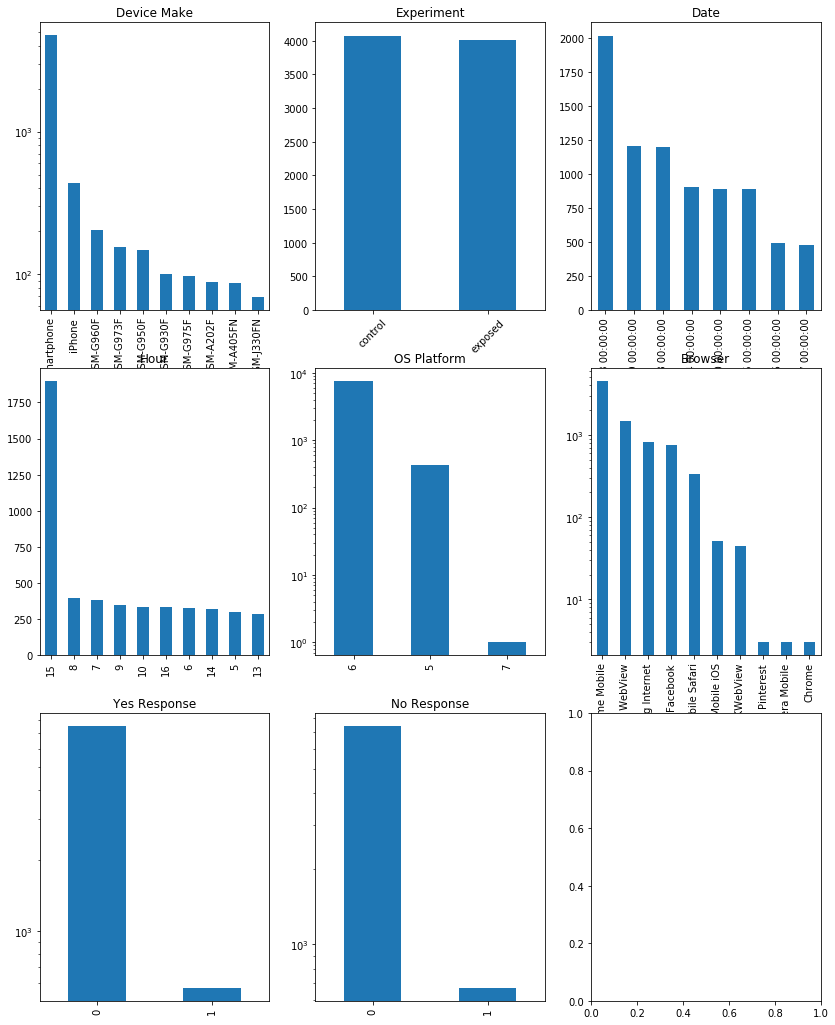

In [106]:
#columns = list(data)
#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,18))

#for col, ax in enumerate(axes):
    #data[columns[col]].value_counts().nlargest(10).plot(kind='bar', title=columns[col])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,18))
#plt.xtick_labels(rotation=45)

data['device_make'].value_counts().nlargest(10).plot(ax=axes[0, 0], kind='bar',logy=True, title='Device Make')
data['experiment'].value_counts().plot(ax=axes[0, 1], kind='bar', title='Experiment', rot=45)
data['date'].value_counts().plot(ax=axes[0, 2], kind='bar', title='Date')
data['hour'].value_counts().nlargest(10).plot(ax=axes[1, 0], kind='bar', title='Hour')
data['platform_os'].value_counts().plot(ax=axes[1, 1], kind='bar', logy=True, title='OS Platform')
data['browser'].value_counts().nlargest(10).plot(ax=axes[1, 2], kind='bar', logy=True, title='Browser')
data['yes'].value_counts().plot(ax=axes[2, 0], kind='bar', logy=True, title='Yes Response')
data['no'].value_counts().plot(ax=axes[2, 1], kind='bar', logy=True, title='No Response')

### Histogram

Text(0.5, 1.0, 'Distribution of Hour of response')

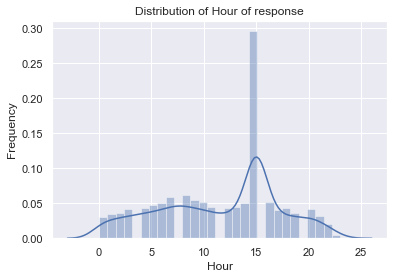

In [121]:
sns.distplot(data['hour'])
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Distribution of Hour of response')

### Relational Plots

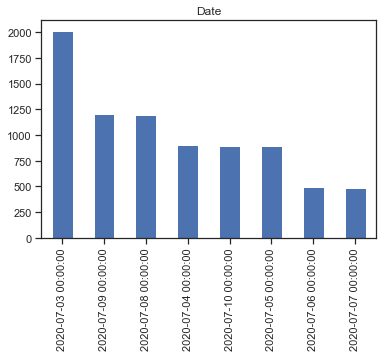

In [127]:
data['date'].value_counts().plot(kind='bar', title='Date')

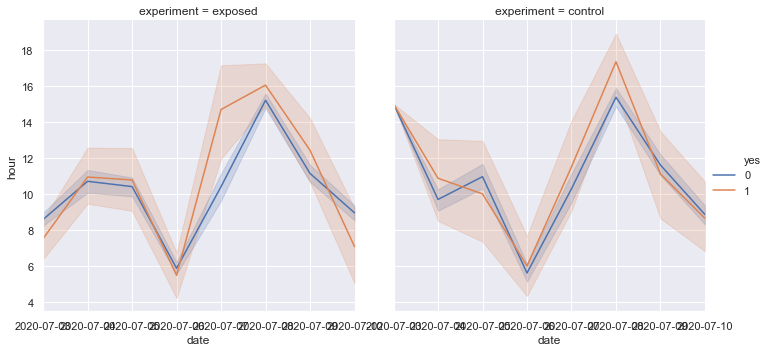

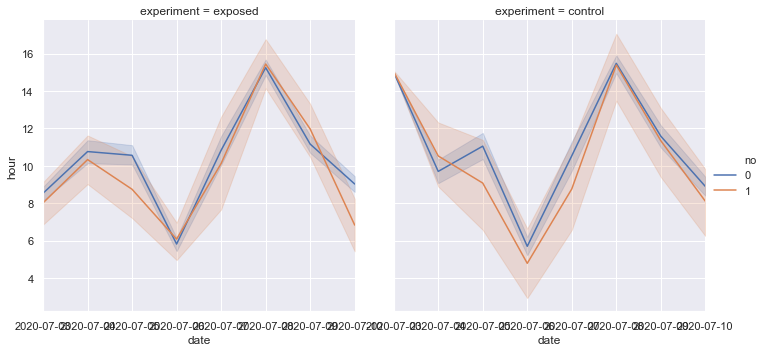

In [148]:
ax = sns.relplot(x='date', y='hour', data=data, col='experiment', hue='yes', kind='line')
ax.set(xlim=([datetime.date(2020, 7, 3), datetime.date(2020, 7, 10)]))

ax1 = sns.relplot(x='date', y='hour', data=data, col='experiment', hue='no', kind='line')
ax1.set(xlim=([datetime.date(2020, 7, 3), datetime.date(2020, 7, 10)]))

#date_form = DateFormatter("%d-%m")
#ax.set_major_formatter(date_form)

## Hypothesis Testing

# A/B Testing using Machine Learning
Our problem is best framed as a binary classification (Yes or No response to a questionnaire), which predicts whether the advertising campaign conducted by SmartAd resulted in a significant lift in brand awareness or not.
Our dataset consists of 8077 users who were shown a dummy ad or a creative, online interactive ad with the SmartAd brand randomly; with the Yes or No response to the questionnaire and the date and hour of their response, and the users' device, platform OS, and browser used to view the questionnaire.
Each user, uniquely identified by an impression id, is given a label out of three possible options (aware, not aware, no response), based on their response.
Our target is to predict brand awareness, represented by the `Yes` response, therefore, our target variable is the yes feature.

## Training and Testing Sets
First, we split our data into training and testing sets with a 90% - 10% ratio using `train_test_split` function from sklearn library.
Therefore, there's need to import the necessary modules first...

In [182]:
from sklearn import linear_model
from sklearn import preprocessing as ppr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [170]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = ppr.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = ppr.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [210]:
ML_data = data.drop(['auction_id','date'], axis=1)
ML_data['target'] = np.where(ML_data['yes'] == 1, 'Aware', (np.where(ML_data['no'] == 1, 'Not Aware', 'No Response')))

ML_data = MultiColumnLabelEncoder(columns = ['experiment','device_make','platform_os','browser','target']).fit_transform(ML_data)
# define the target variable (dependent variable) as y
y = ML_data.target 

ML_data = ML_data.drop(['yes','no','target'], axis=1)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(ML_data, y, test_size=0.1, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(7269, 5) (7269,)
(808, 5) (808,)


## Implementing Machine Learning Algorithms
Next, we apply machine learning to the training data using the following different algorithms.
* Linear Regression
* Logistic Regression
* Decision Trees
* XGBoost

### Linear Regression

Mean Square Error is : 0.12743933178186445 
Root Mean Square Error is : 0.3569864588214299  
R squared Score is : 0.00017362369242146514


Text(0, 0.5, 'Predictions')

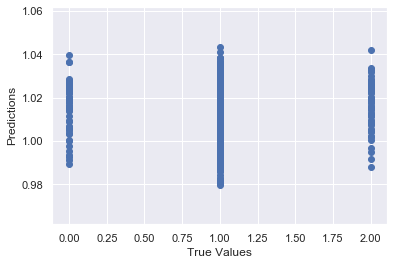

In [228]:
# fit a model on the training data
lm = linear_model.LinearRegression()
lreg_model = lm.fit(X_train, y_train)

#make predictions using test data
lreg_y_pred = lm.predict(X_test)

#calculating RMSE and R2 Score
mse = mean_squared_error(y_test, lreg_y_pred)
rmse = np.sqrt(mse)

r2_score = lreg_model.score(X_test, y_test)

print('Mean Square Error is :',mse,'\nRoot Mean Square Error is :',rmse,' \nR squared Score is :', r2_score)

#plotting the model
## The line / model
plt.scatter(y_test, lreg_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

### 5-fold Cross Validation

In [192]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

Cross-validated scores: [-0.00039043 -0.00381845  0.00101156 -0.00329423  0.00075083]


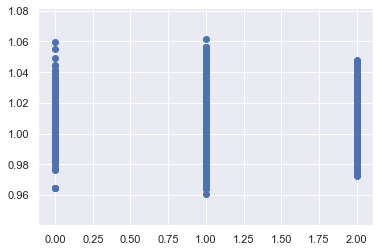

In [212]:
# Perform 5-fold cross validation
lreg_cv_scores = cross_val_score(lreg_model, ML_data, y, cv=5)
print('Cross-validated scores:', lreg_cv_scores)

# Make cross validated predictions
lreg_cv_y_pred = cross_val_predict(lreg_model, ML_data, y, cv=6)
plt.scatter(y, lreg_cv_y_pred)

In [238]:
pd.DataFrame(lm.feature_importances_.reshape(1, -1), columns=list(ML_data))

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

### Logistic Regression

C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on test set: 0.87


Text(0, 0.5, 'Predictions')

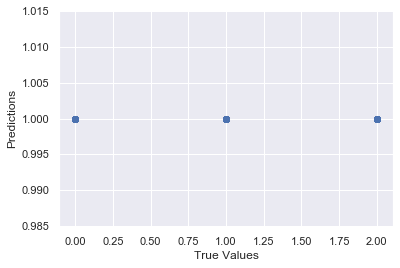

In [230]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg_model = logreg.fit(X_train, y_train)

logreg_y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#plotting the model
## The line / model
plt.scatter(y_test, logreg_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Cross-validated scores: [0.84591584 0.84591584 0.84643963 0.84643963 0.84582043]


C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

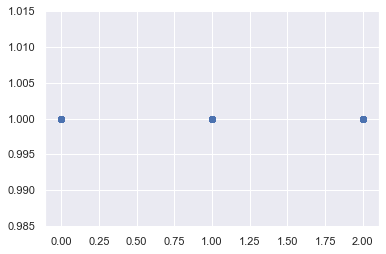

In [231]:
# Perform 5-fold cross validation
logreg_cv_scores = cross_val_score(logreg_model, ML_data, y, cv=5)
print('Cross-validated scores:', logreg_cv_scores)

# Make cross validated predictions
logreg_cv_y_pred = cross_val_predict(logreg_model, ML_data, y, cv=6)
plt.scatter(y, logreg_cv_y_pred)

In [237]:
pd.DataFrame(logreg.feature_importances_.reshape(1, -1), columns=list(ML_data))

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

### Decision Trees

In [218]:
!pip install pydot
!pip install graphviz

In [219]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

In [232]:
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train, y_train)

dt_y_pred = dt.predict(X_test)

awareness = np.array(y_test)
dt_predictions = np.array(dt_y_pred)
confusion_matrix(awareness, dt_predictions)

array([[  0,  49,   1],
       [ 26, 659,  20],
       [  3,  49,   1]], dtype=int64)

Cross-validated scores: [0.80569307 0.79517327 0.80371517 0.7869969  0.80309598]


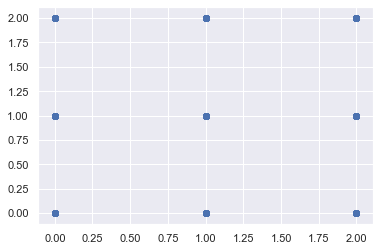

In [233]:
# Perform 5-fold cross validation
dt_cv_scores = cross_val_score(dt_model, ML_data, y, cv=5)
print('Cross-validated scores:', dt_cv_scores)

# Make cross validated predictions
dt_cv_y_pred = cross_val_predict(dt_model, ML_data, y, cv=6)
plt.scatter(y, dt_cv_y_pred)

In [236]:
pd.DataFrame(dt.feature_importances_.reshape(1, -1), columns=list(ML_data))

,experiment,hour,device_make,platform_os,browser
0,0.023188,0.447145,0.482841,0.0,0.046826


### XGBoost

In [223]:
import xgboost as xgb

In [234]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

xg_model = regressor.fit(X_train, y_train)

xg_y_pred = regressor.predict(X_test)

xg_mse = mean_squared_error(y_test, xg_y_pred)
xg_rmse = np.sqrt(xg_mse)

print('Mean Squared Error of XGBoost model is : ',xg_mse,'\nRoot Mean Squared Error of XGBoost model is : ', xg_rmse)

[06:42:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Squared Error of XGBoost model is :  0.12989727353506653 
Root Mean Squared Error of XGBoost model is :  0.3604126434173287


[06:43:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross-validated scores: [ 0.00024509 -0.03108185 -0.01230869 -0.01002037 -0.0014459 ]
[06:43:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

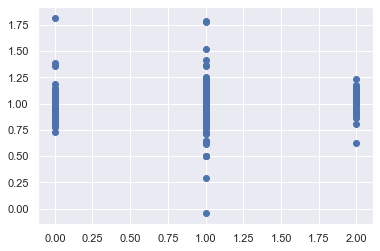

In [235]:
# Perform 5-fold cross validation
xg_cv_scores = cross_val_score(xg_model, ML_data, y, cv=5)
print('Cross-validated scores:', xg_cv_scores)

# Make cross validated predictions
xg_cv_y_pred = cross_val_predict(xg_model, ML_data, y, cv=6)
plt.scatter(y, xg_cv_y_pred)

In [226]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=list(ML_data))

,experiment,hour,device_make,platform_os,browser
0,0.202763,0.195139,0.21396,0.169612,0.218525
